In [2]:
import numpy as np
import scipy.stats as st
import pandas as pd
import torch
import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg

%matplotlib inline

In [3]:
x = np.empty(3000)
x[0] = 0
x[1] = np.random.randn()
theta_1 = 0.6
theta_2 = 0.3

for i in range(2, len(x)):
    x[i] = theta_1 * x[i-1] + theta_2 * x[i-2] + np.random.randn()

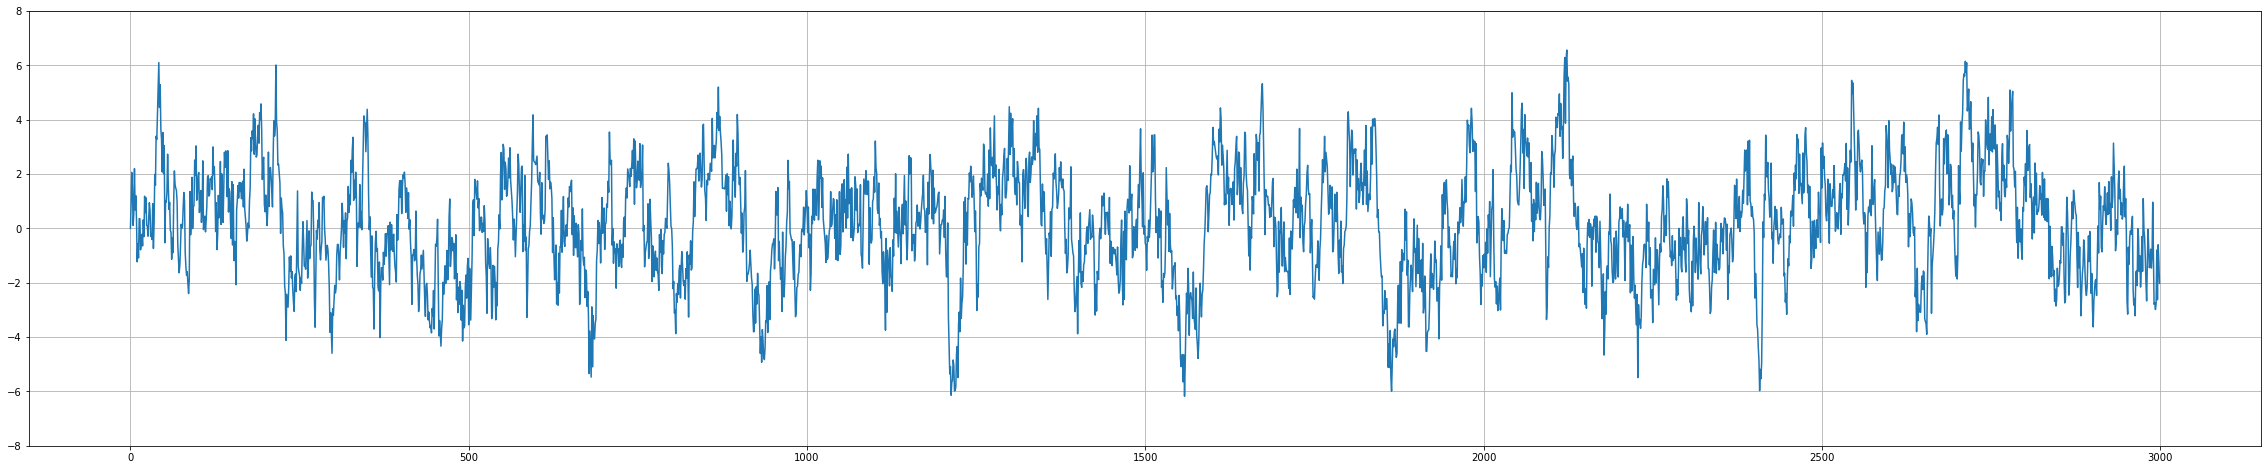

In [4]:
fig, ax = plt.subplots(figsize=(40, 8))
ax.plot(x)
ax.grid(True)
ax.set_ylim(-8, 8);

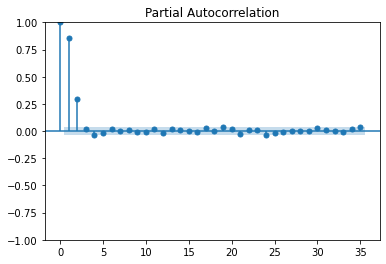

In [5]:
plot_pacf(x, method="ywm");

In [6]:
ar_model = AutoReg(x, lags=2).fit()
print(ar_model.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 3000
Model:                     AutoReg(2)   Log Likelihood               -4292.580
Method:               Conditional MLE   S.D. of innovations              1.013
Date:                Thu, 03 Mar 2022   AIC                           8593.161
Time:                        14:45:08   BIC                           8617.183
Sample:                             2   HQIC                          8601.802
                                 3000                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0162      0.019      0.871      0.384      -0.020       0.053
y.L1           0.6047      0.017     34.605      0.000       0.570       0.639
y.L2           0.2909      0.017     16.644      0.0

In [9]:
pred = ar_model.predict(start=0, end=len(x)-1, dynamic=False)

## Sum of loglikelihoods

In [10]:
sum(st.norm.logpdf(x[2:], loc=pred[2:], scale=1))

-4293.081683307066

# Conditional flow

In [11]:
x_norm = x / np.std(x)

In [12]:
dist_base = dist.Normal(torch.zeros(1), torch.ones(1))
dist_x1 = dist.TransformedDistribution(dist_base, [])

In [13]:
x2_transform = T.conditional_spline(1, context_dim=2)
dist_x2_given_x1 = dist.ConditionalTransformedDistribution(dist_base, [x2_transform])

In [17]:
%%time
steps = 5001
modules = torch.nn.ModuleList([x2_transform])
optimizer = torch.optim.Adam(modules.parameters(), lr=3e-3)
x1 = np.vstack((x_norm[:-2], x_norm[1:-1])).T
x2 = x_norm[2:][:, None]

x1 = torch.tensor(x1, dtype=torch.float)
x2 = torch.tensor(x2, dtype=torch.float)
for step in range(steps):
    optimizer.zero_grad()
    ln_p_x2_given_x1 = dist_x2_given_x1.condition(x1.detach()).log_prob(x2.detach())
    loss = -(ln_p_x2_given_x1).mean()
    loss.backward()
    optimizer.step()
    dist_x1.clear_cache()
    dist_x2_given_x1.clear_cache()
    
    if step%500 ==0:
        print("step : {}, loss {}".format(step, loss.item()))
                    

step : 0, loss 1.6005058288574219
step : 500, loss 0.7313017249107361
step : 1000, loss 0.7202128767967224
step : 1500, loss 0.7156362533569336
step : 2000, loss 0.7155206203460693
step : 2500, loss 0.7083643078804016
step : 3000, loss 0.708122730255127
step : 3500, loss 0.706786036491394
step : 4000, loss 0.707759439945221
step : 4500, loss 0.7098521590232849
step : 5000, loss 0.7060546278953552
Wall time: 1min 10s


In [19]:
pred_flow = dist_x2_given_x1.condition(x1).sample((10000, x1.shape[0]))
pred_flow = pred_flow.detach().numpy() * np.std(x)

## sum of loglikelihoods

In [20]:
sum(st.norm.logpdf(x[2:], loc=pred_flow.mean(axis=0).ravel(), scale=np.std(pred_flow, axis=0).ravel()))

-4291.247789738945

# graphs

## 1-step ahead prediction OLS

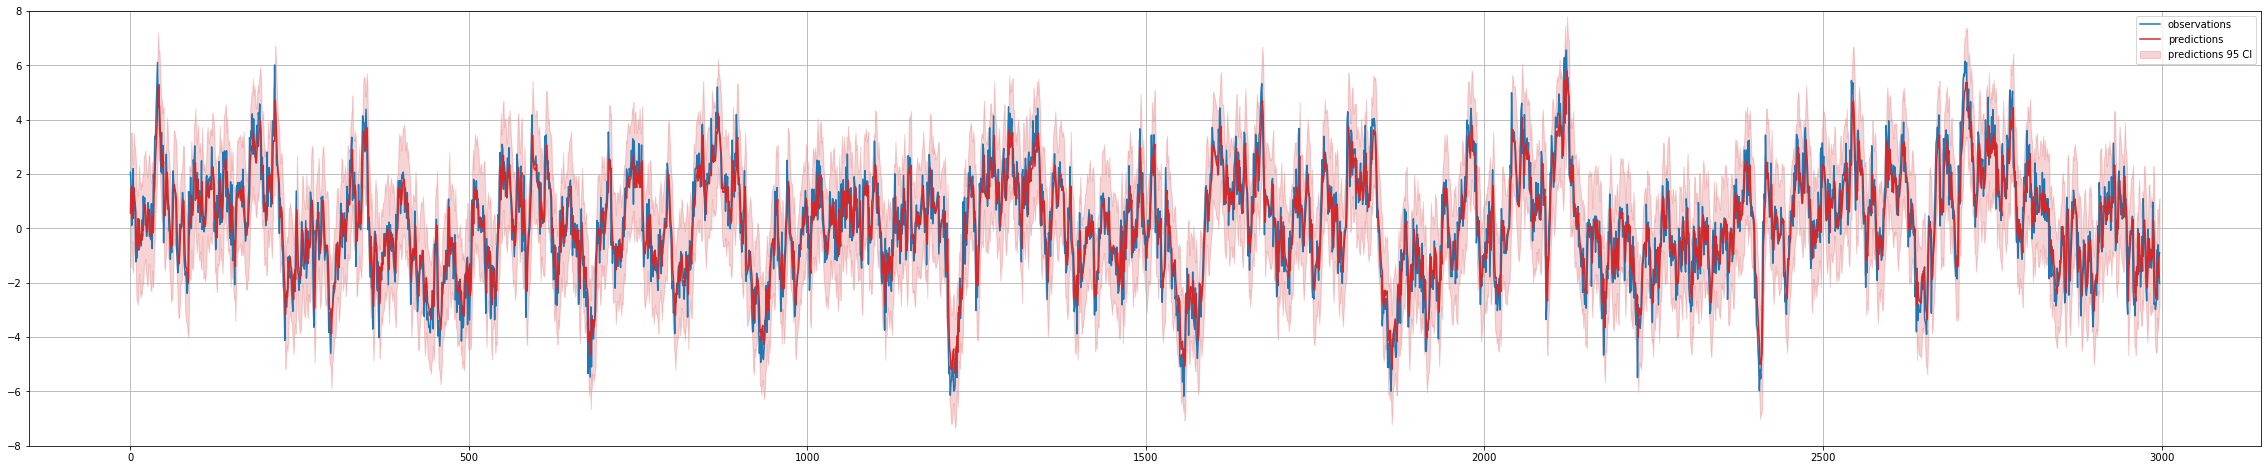

In [24]:
fig, ax = plt.subplots(figsize=(40, 8))
ax.plot(x[2:], label="observations")
ax.plot(pred[2:], c="tab:red", label="predictions")
ax.fill_between(np.arange(2998), pred[2:]-2, pred[2:]+2, color="tab:red", alpha=0.2, label="predictions 95 CI")
ax.grid(True)
ax.set_ylim(-8, 8)
ax.legend();

## 1-step ahead prediction flow

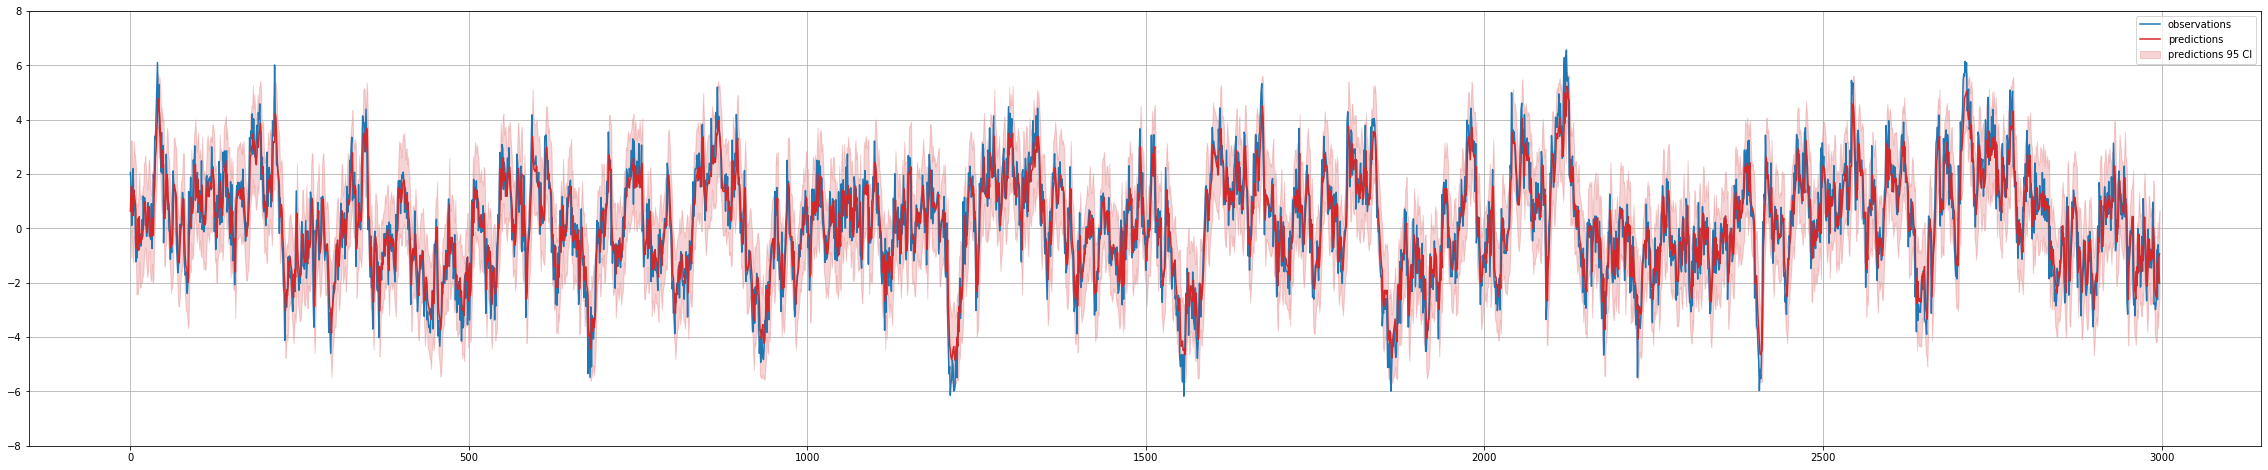

In [27]:
fig, ax = plt.subplots(figsize=(40, 8))
ax.plot(x[2:], label="observations")
ax.plot(pred_flow.mean(axis=0).ravel(), c="tab:red", label="predictions")
ax.fill_between(np.arange(2998), np.quantile(pred_flow, 0.05, axis=0).ravel(), np.quantile(pred_flow, 0.95, axis=0).ravel(), color="tab:red", alpha=0.2, label="predictions 95 CI")
ax.grid(True)
ax.set_ylim(-8, 8)
ax.legend();